# Deep-Flow: Generative Hallucination Test
In this notebook, we test if the model has learned the "Probability Flow" of expert driving.
We sample noise and integrate forward to t=1.

In [1]:
import matplotlib
# Compatibility patch for Matplotlib 3.6.1 and VS Code/matplotlib-inline
if not hasattr(matplotlib.RcParams, '_get'):
    matplotlib.RcParams._get = lambda self, key: self.get(key)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.deep_flow import DeepFlow
from src.dataset.waymo_dataset import WaymoDataset
from src.utils.visualization import plot_scenario
from omegaconf import OmegaConf

print("✅ Environment patched and modules loaded.")

✅ Environment patched and modules loaded.


## 1. Load Model & Data
We load the best checkpoint and a sample from the validation set.

In [2]:
cfg = OmegaConf.load("../configs/main_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load PCA Basis
pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
with open(pca_path, "r") as f:
    pca_data = json.load(f)

PCA_COMP = torch.tensor(pca_data['components'], device=device).float() # [12, 160]
PCA_MEAN = torch.tensor(pca_data['mean'], device=device).float()       # [160]
PCA_STDS = torch.tensor(pca_data['stds'], device=device).float()       # [12]
SCALE_POS = 50.0

# 2. Initialize Model
model = DeepFlow(cfg).to(device)
checkpoint_path = "../checkpoints/best_model.pth"

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model'])
    print("✅ Checkpoint loaded.")
else:
    print("⚠️ No checkpoint found. Using random weights.")

model.eval()

# 3. Load Data
val_set = WaymoDataset(cfg, split='validation', in_memory=True)

/home/anton/Deep-Flow/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


✅ Checkpoint loaded.
🚀 Parallel Eager Load (20 workers)...


100%|██████████| 8856/8856 [00:16<00:00, 539.34it/s]

✅ validation split loaded. Count: 8856


## 2. The Generation Engine (Euler ODE Solver)
To generate, we solve: $dx/dt = v_\theta(x, t, C)$ from $t=0 \to t=1$.

In [3]:
@torch.no_grad()
def generate_goal_conditioned_trajectories(model, batch_torch, num_samples=20, steps=30):
    device = next(model.parameters()).device
    
    # 1. Load PCA Basis (Now 12 components)
    pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
    import json
    with open(pca_path, "r") as f:
        pca_data = json.load(f)
        
    pca_comp = torch.tensor(pca_data['components'], device=device).float() # [12, 160]
    pca_mean = torch.tensor(pca_data['mean'], device=device).float()       # [160]
    # We load stds but we won't use them if we stopped whitening in the trainer
    
    SCALE_POS = 50.0 

    # 2. Encode Scene (Returns Tuple now)
    context, goal_emb = model.encoder(
        batch_torch['agent_context'], 
        batch_torch['agent_mask'], 
        batch_torch['map_context'], 
        batch_torch['map_mask'],
        batch_torch['goal_pos'],
        batch_torch['goal_lane']
    )
    
    context = context.repeat(num_samples, 1)
    goal_emb = goal_emb.repeat(num_samples, 1)

    # 3. Integrate in 12D PCA space
    curr_coeffs = torch.randn(num_samples, 12, device=device) # Updated to 12
    dt = 1.0 / steps
    
    for i in range(steps):
        t = torch.ones(num_samples, device=device) * (i * dt)
        # Head now expects 4 arguments: (xt, t, context, goal_emb)
        v_t = model.flow_head(curr_coeffs, t, context, goal_emb)
        curr_coeffs = curr_coeffs + v_t * dt

    # 4. RECONSTRUCTION
    # CRITICAL: We NO LONGER multiply by PCA_STDS here 
    # because the trainer is now learning raw PCA coefficients.
    
    # Inverse PCA: [Samples, 12] @ [12, 160] + [160]
    trajs_norm = torch.matmul(curr_coeffs, pca_comp) + pca_mean
    
    # Un-scale to Meters
    trajs_meters = trajs_norm.view(num_samples, 80, 2) * SCALE_POS 
    
    return trajs_meters.cpu().numpy()

## 3. Run Generation & Visualize
We pick a scenario, generate "hallucinations," and overlay them on the map.

✅ Found Raw Data: /mnt/d/waymo_datasets/Deep-Flow_Dataset/processed_npz/validation/c1/c189070365a0efe.npz
📉 Loss for Scenario c189070365a0efe: 0.0796


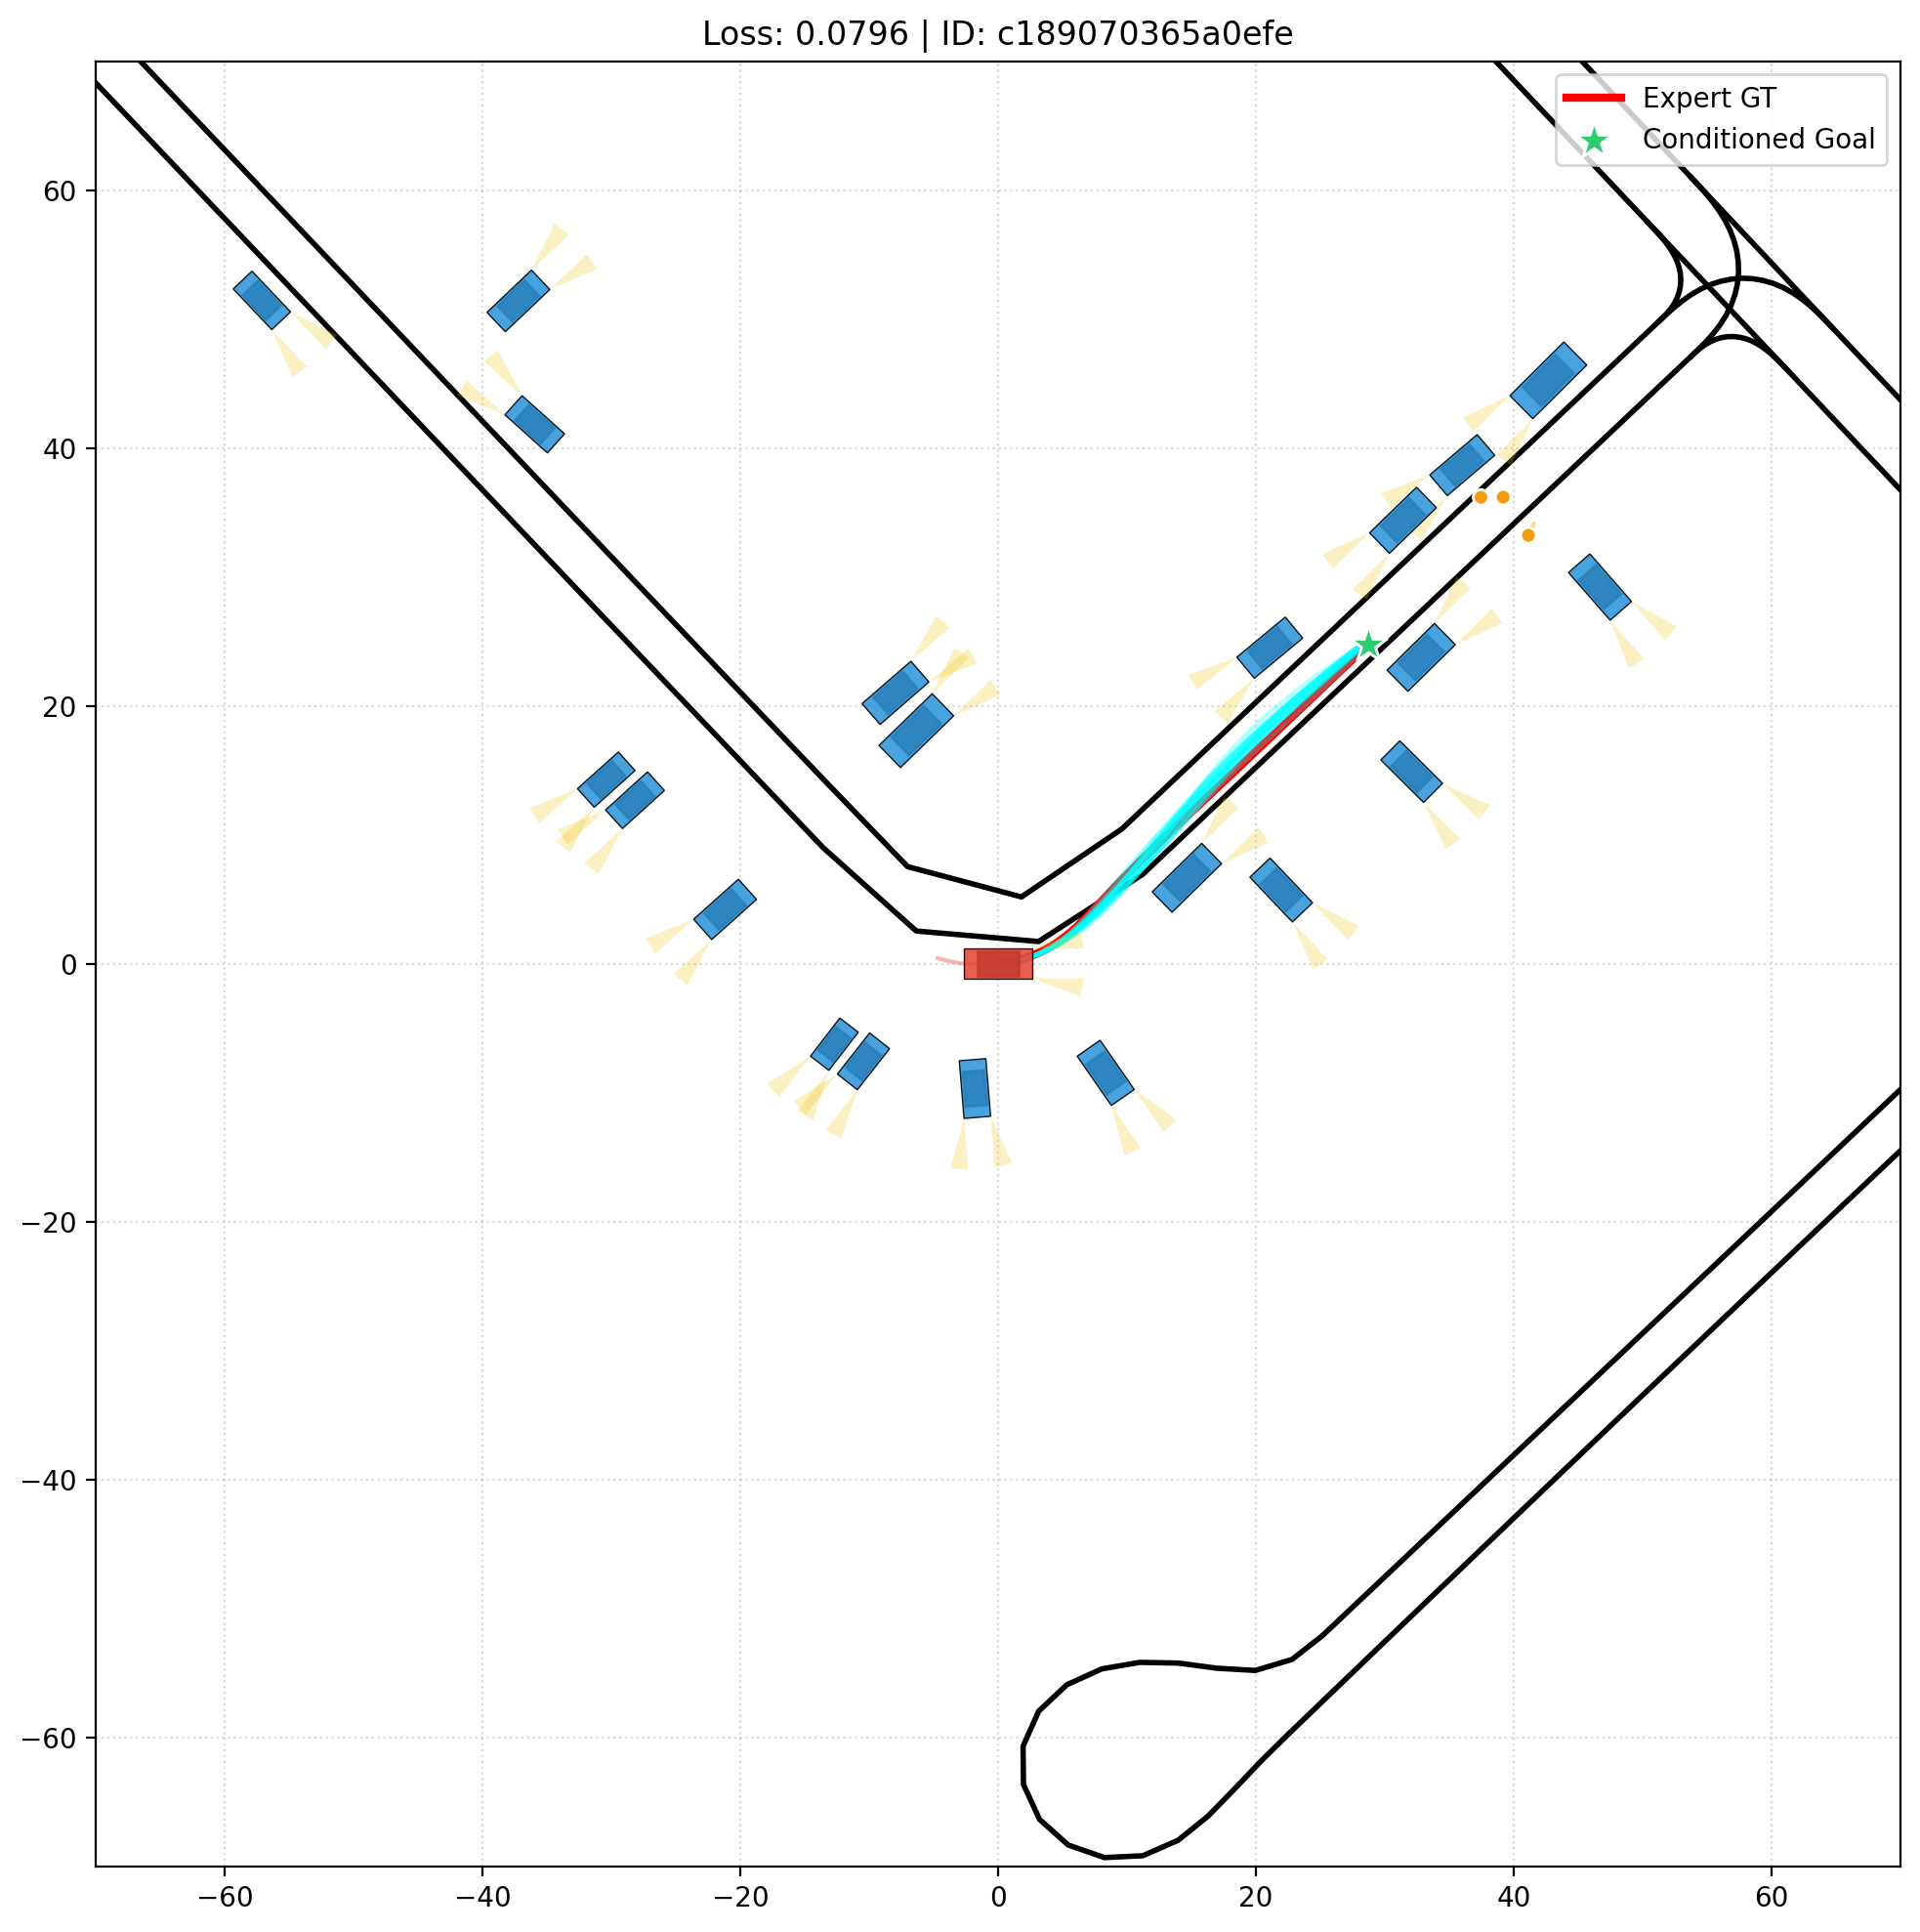

In [4]:
# Import the loss function
from src.engine.losses import CFMLoss

# 1. Pick a batch from the dataset
idx = 0 # Pick any index from RAM
batch = val_set[idx]
sc_id = batch['scenario_id']

# 2. Find the corresponding Raw File on Disk
# We search the file_list for the file that contains this scenario ID
found_path = None
for path in val_set.file_list:
    if sc_id in path:
        found_path = path
        break

if found_path is None:
    print(f"❌ Could not find raw file for ID {sc_id}")
else:
    print(f"✅ Found Raw Data: {found_path}")
    raw_data = np.load(found_path)

    # 3. Setup Torch Batch
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}

    # --- Compute Loss for this specific scenario ---
    criterion = CFMLoss(cfg=cfg, sigma_min=1e-4).to(device)
    with torch.no_grad():
        loss_val, flow_loss, coord_loss = criterion(model, batch_torch)
        loss_val = loss_val.item()
    print(f"📉 Loss for Scenario {sc_id}: {loss_val:.4f}")

    # 4. Generate
    hallucinations = generate_goal_conditioned_trajectories(model, batch_torch, num_samples=20, steps=50)

    # 5. Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot Map (From Raw Data)
    plot_scenario(raw_data, ax=ax, show_future=False)

    # Plot Hallucinations
    for i in range(len(hallucinations)):
        ax.plot(hallucinations[i, :, 0], hallucinations[i, :, 1], 
                color='cyan', alpha=0.3, linewidth=1.5, zorder=10)

    # Plot Expert GT (From Raw Data)
    gt_future = raw_data['agents'][0, 11:91, :2]
    ax.plot(gt_future[:, 0], gt_future[:, 1], color='red', linewidth=3, label='Expert GT', zorder=6)

    # Plot Goal

    # Load stats again just for this plot helper
    with open("/mnt/d/waymo_datasets/Deep-Flow_Dataset/stats.json", "r") as f: stats = json.load(f)
    a_mean = np.array(stats['agents']['mean'][:2])
    a_std = np.array(stats['agents']['std'][:2])
    
    goal_norm = batch['goal_pos'].numpy()
    goal_m = goal_norm * 50.0 
    
    ax.scatter(goal_m[0], goal_m[1], color='#2ecc71', s=200, edgecolors='white', 
               label='Conditioned Goal', zorder=10, marker='*')

    ax.set_title(f"Loss: {loss_val:.4f} | ID: {sc_id}")
    plt.legend()
    plt.show()

visualizing Discovery: 2027293e213bc361


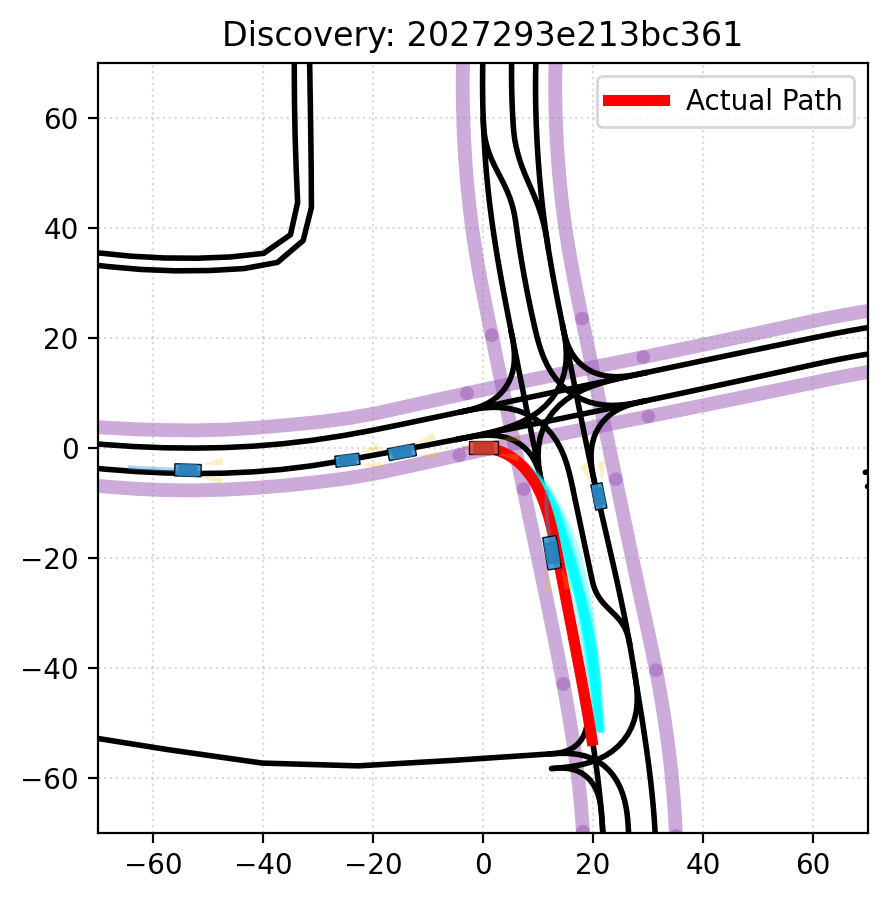

visualizing Discovery: 66699cf0ec4e0fb7


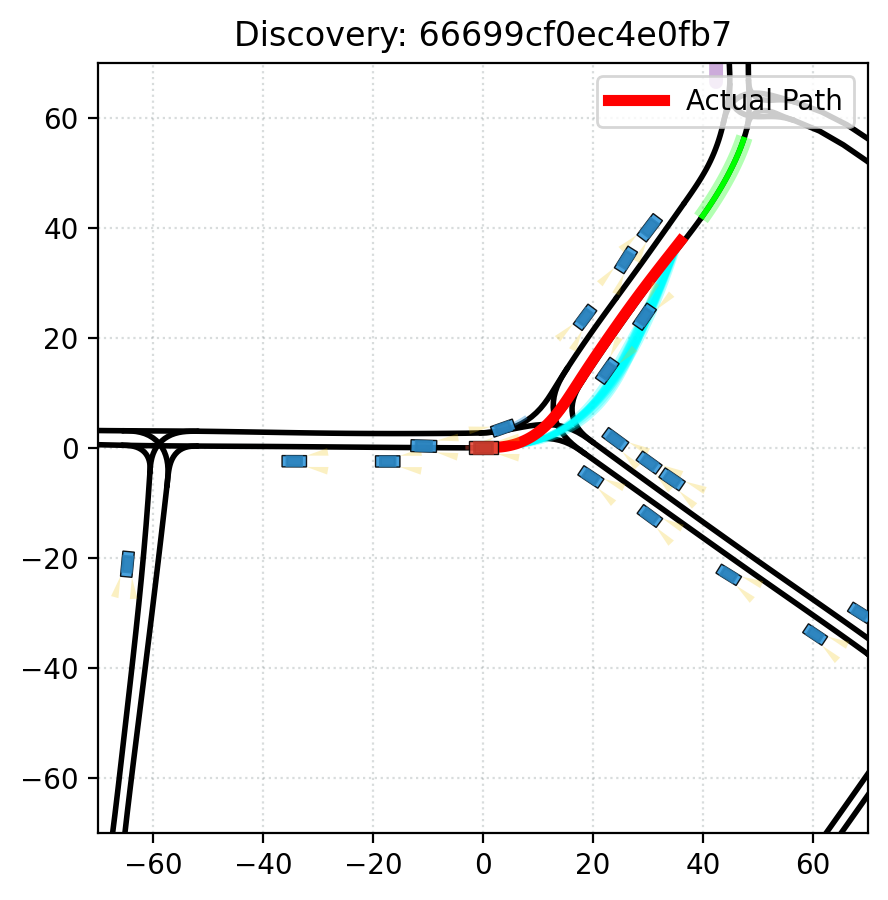

visualizing Discovery: ef5da6c66f8230f8


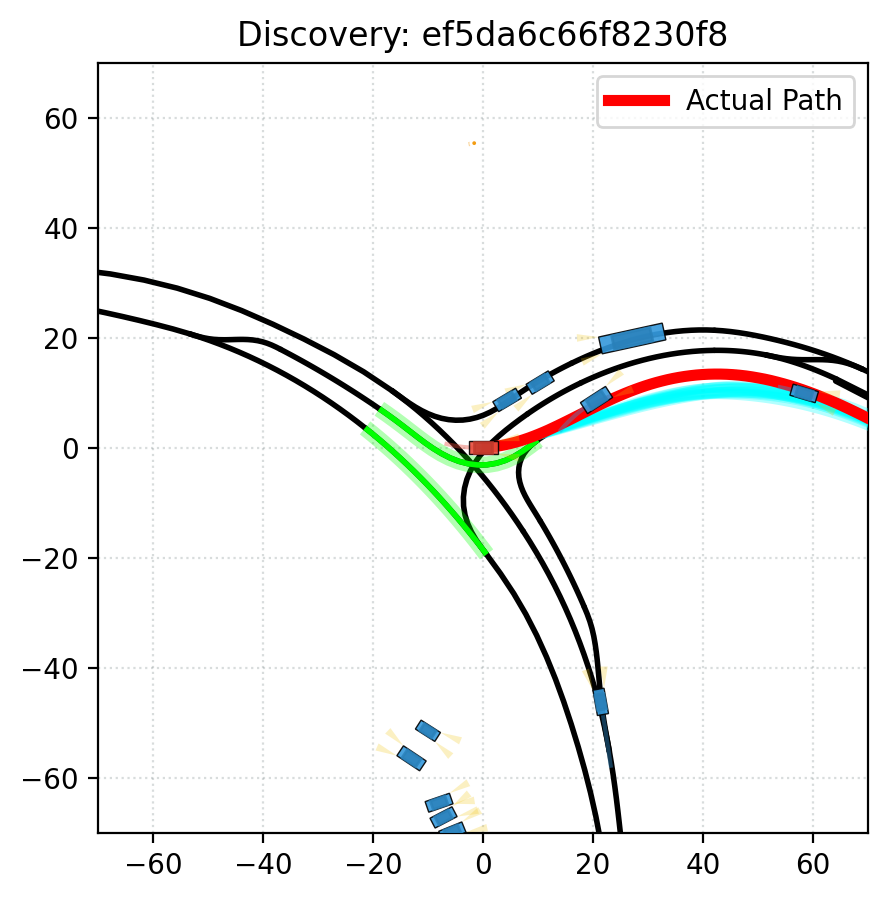

visualizing Discovery: 91ed234f60c3501f


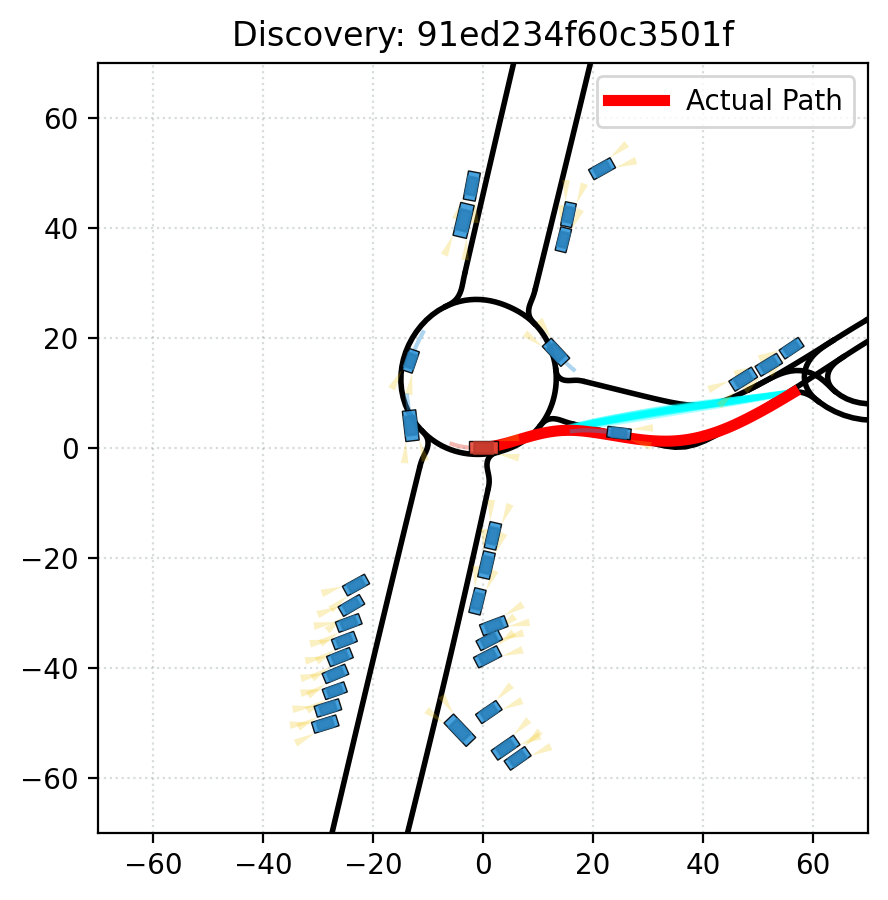

visualizing Discovery: 6307508426e85026


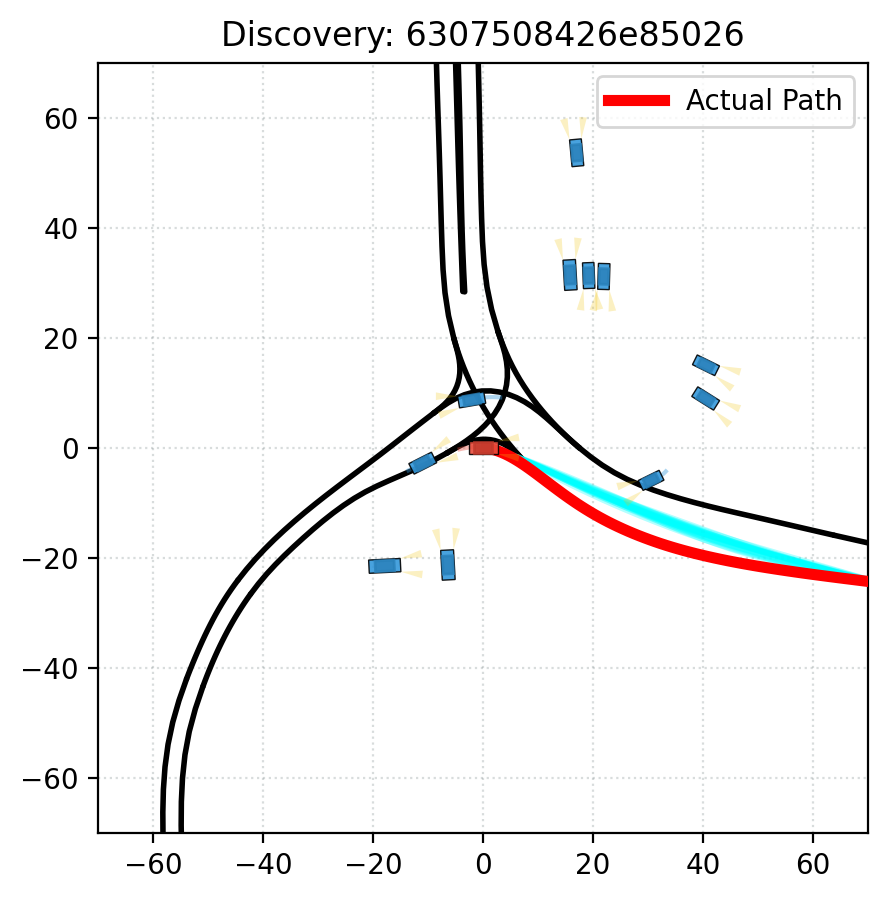

In [7]:
ids_to_check = [
    '2027293e213bc361',
    '66699cf0ec4e0fb7',
    'ef5da6c66f8230f8',
    '91ed234f60c3501f',
    '6307508426e85026',
]

# Loop and Plot
for target_id in ids_to_check:
    print(f"visualizing Discovery: {target_id}")
    
    # 1. Find index in dataset
    # We search the cache since we are using in_memory=True (or file list if False)
    # Note: This linear search is slow but fine for 5 items.
    found_idx = -1
    for i in range(len(val_set)):
        if val_set.data_cache[i][8] == target_id: # Index 8 is scenario_id in tuple
            found_idx = i
            break
            
    if found_idx == -1:
        print(f"Could not find ID {target_id} in validation set.")
        continue

    # 2. Get Data
    batch = val_set[found_idx]
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}
    
    # Find Raw File for Map
    raw_path = next(p for p in val_set.file_list if target_id in p)
    raw_data = np.load(raw_path)

    # 3. Generate
    hallucinations = generate_goal_conditioned_trajectories(model, batch_torch, num_samples=30, steps=50)

    # 4. Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_scenario(raw_data, ax=ax, show_future=False)

    # Cyan Hallucinations (What a Safe Expert WOULD do)
    for i in range(len(hallucinations)):
        ax.plot(hallucinations[i, :, 0], hallucinations[i, :, 1], 
                color='cyan', alpha=0.3, linewidth=1.5, zorder=5)

    # Red Ground Truth (What the Driver ACTUALLY did)
    gt_future = raw_data['agents'][0, 11:91, :2]
    ax.plot(gt_future[:, 0], gt_future[:, 1], color='red', linewidth=4, label='Actual Path', zorder=6)

    ax.set_title(f"Discovery: {target_id}")
    plt.legend()
    
    # Save the figure as pdf if needed
    plt.savefig(f"../results/discovery_{target_id}.pdf", bbox_inches='tight')
    plt.show()